# Getting answers

Load first 100 questions.

In [ ]:
import json

questions_file_name = "../questions/final_questions.json"
question_answer_pairs = json.loads(open(questions_file_name).read())

questions = [qa["question"] for qa in question_answer_pairs]
questions = questions[:100]

Request answer from server.

In [ ]:
import requests
from datetime import datetime

def get_info_from_rag(question: str):
    prompt_template = f"{question}"
    response = requests.post(
        f"http://127.0.0.1:5555/rags",
        json={"text": f"{prompt_template}"},
    )
    
    return response.json()


current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
bot_responses_file_name = f"bot_responses_{current_time}.json"
with open(bot_responses_file_name, "w") as f:
    i = 1
    num_of_quest = len(questions)
    for question in questions:
        print(f"Processing question {i}/{num_of_quest}")
        
        rag_info = get_info_from_rag(question)
        rag_response = rag_info["data"]
        f.write(json.dumps(rag_response) + ",\n")
        
        i += 1
        
print("--- DONE ---")

Combine reference answer and the bot answer

In [ ]:
bot_answers = json.loads(open("bot_responses_20241030_180851.json").read())

test_data = []
for i, bot_answer in enumerate(bot_answers):
    test_data.append({
        "context": question_answer_pairs[i]["context"],
        "question": question_answer_pairs[i]["question"],
        "reference_answer": question_answer_pairs[i]["answer"],
        "bot_answer": bot_answer,
    })
    
combined_file_name = f"combined_{current_time}.json"
with open(combined_file_name, "w") as f:
    f.write(json.dumps(test_data))

# Evaluate QA performance

Load questions and answers dataset.

In [ ]:
# Load the combined file
qa_data = json.loads(open(combined_file_name).read())
qa_len = len(qa_data)
qa_len

## SaCC and LaCC

In [ ]:
def sacc(reference: str, answer: str):
    return 1 if reference == answer else 0

def lacc(reference: str, answer: str):
    ref_tokens = reference.split()
    answer_tokens = answer.split()
    
    common_tokens = set(ref_tokens).intersection(set(answer_tokens))
    
    return 1 if len(common_tokens) > 0 else 0

In [ ]:
sacc_score = 0
lacc_score = 0

for qa in qa_data:
    sacc_score += sacc(qa["reference_answer"], qa["bot_answer"])
    lacc_score += lacc(qa["reference_answer"], qa["bot_answer"])
    
final_sacc_score = sacc_score / qa_len
final_lacc_score = lacc_score / qa_len

print(f"SACC: {final_sacc_score}")
print(f"LACC: {final_lacc_score}")

## F1 score

In [ ]:
def precision(reference: str, answer: str):
    ref_tokens = reference.split()
    answer_tokens = answer.split()
    
    common_tokens = set(ref_tokens).intersection(set(answer_tokens))
    
    return len(common_tokens) / len(answer_tokens)

def recall(reference: str, answer: str):
    ref_tokens = reference.split()
    answer_tokens = answer.split()
    
    common_tokens = set(ref_tokens).intersection(set(answer_tokens))
    
    return len(common_tokens) / len(ref_tokens)

def f1_score(reference: str, answer: str):
    prec = precision(reference, answer)
    rec = recall(reference, answer)
    
    if prec + rec == 0:
        return 0
    
    return 2 * ((prec * rec) / (prec + rec))

In [ ]:
f1 = 0

for qa in qa_data:
    f1 += f1_score(qa["reference_answer"], qa["bot_answer"])
    
final_f1 = f1 / qa_len
print(f"F1: {final_f1}")

## G-eval

Enter OPENAi API key to get G-eval score

In [ ]:
%env OPENAI_API_KEY=

Define metrics.

In [ ]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

correctness_metric = GEval(
    name="Correctness",
    criteria="The actual output must provide the correct information, adhering to the facts or knowledge available on the topic. The expected output is the ground truth.",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

completeness_metric = GEval(
    name="Completeness",
    criteria="The actual output should be comprehensive enough to cover all essential parts of the input, without omitting critical information.",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

relevance_metric = GEval(
    name="Relevance",
    criteria="The actual output must directly address the input without including unnecessary or unrelated information.",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

Evaluate QA performance using G-eval on correctness.

In [ ]:
from deepeval.test_case import LLMTestCase
from deepeval import evaluate

# Create test cases
g_test_cases = []
i = 1
for qa in qa_data:
    test_case = LLMTestCase(
        input=qa["question"],
        actual_output=qa["bot_answer"],
        expected_output=qa["reference_answer"],
    )
    
    g_test_cases.append(test_case)

# Evaluate
g_correct_result = evaluate(g_test_cases, metrics=[correctness_metric])
g_correct_result

Evaluate QA performance using G-eval on completeness.

In [ ]:
g_completeness_result = evaluate(g_test_cases, metrics=[completeness_metric])
g_completeness_result

Evaluate QA performance using G-eval on relevance.

In [ ]:
g_relevance_result = evaluate(g_test_cases, metrics=[relevance_metric])
g_relevance_result

## Hallucination evaluation

In [ ]:
from deepeval import evaluate
from deepeval.metrics import HallucinationMetric
from deepeval.test_case import LLMTestCase

hallucination_test_cases = []
for qa in qa_data:
    test_case = LLMTestCase(
        input=qa["question"],
        expected_output=qa["reference_answer"],
        actual_output=qa["bot_answer"],
        context=[qa["context"]],
    )
    
    hallucination_test_cases.append(test_case)
    
hallucinatin_metric = HallucinationMetric(threshold=0.5)

h_result = evaluate(hallucination_test_cases, [hallucinatin_metric])
h_result

# Conclusion

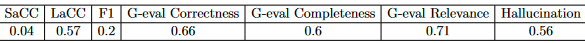